In [1]:
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [2]:
ds = pd.read_csv('data/meteo.csv')

ds.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
ds['Ok'] = False
ds.loc[
    (ds['Temperature (C)'] > 0) & (ds['Wind Speed (km/h)'] < 14) & (ds['Visibility (km)'] > 15),
    'Ok'
] = True

In [4]:
ds['Ok_13'] = ds['Ok'].rolling(13, center=True).sum()

In [5]:
print(len(ds.loc[ds['Ok_13'] == True]))

10249


In [6]:
ds.dropna(inplace=True)

In [7]:
ds = ds[['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)', 'Ok']]

ds = ds.values

In [8]:
features = ds[:, :3]
labels = ds[:, 3]

max_features = np.max(features, axis=0)
min_features = np.min(features, axis=0)

features = (features - min_features) / (max_features - min_features)

In [9]:
step = 13

x = np.zeros((len(features), step, len(features[0])), dtype='float32')
y = np.zeros((len(labels), step), dtype='float32')

for id in range(0, len(features) - step):
    x[id] = features[id:id + step]
    y[id] = labels[id:id + step]

In [10]:
x_train = x[:90000]
y_train = y[:90000]

x_test = x[90000:]
y_test = y[90000:]

In [29]:
# costruzione del modello basato su LSTM

# creazione di un input per una sequenza di
# lunghezza variabile di interi
inputs = keras.Input(shape=(x_train.shape[1:]))

# aggiunta di due layer LSTM
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
x = layers.Dense(8, activation='swish')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(step, activation='sigmoid')(x)
lstm_model = keras.Model(inputs, outputs, name='lstm')
lstm_model.summary()

lstm_model.compile(keras.optimizers.Adam(), "mse", metrics='binary_accuracy')

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 13, 3)]           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 13, 8)             384       
_________________________________________________________________
lstm_17 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 13)                117       
Total params: 1,117
Trainable params: 1,117
Non-trainable params: 0
____________________________________________________________

In [30]:
# costruzione del modello basato su Bidirectional LSTM

# creazione di un input per una sequenza di
# lunghezza variabile di interi
inputs = keras.Input(shape=(x_train.shape[1:]))

# aggiunta di due layer LSTM
x = layers.Bidirectional(layers.LSTM(8, return_sequences=True), merge_mode='ave')(inputs)
x = layers.Bidirectional(layers.LSTM(8), merge_mode='ave')(x)
x = layers.Dense(8, activation='swish')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(step, activation='sigmoid')(x)
bidirectional_model = keras.Model(inputs, outputs, name='bidirectional')
bidirectional_model.summary()

bidirectional_model.compile(keras.optimizers.Adam(), "mse", metrics='binary_accuracy')

Model: "bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 13, 3)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 13, 8)             768       
_________________________________________________________________
bidirectional_9 (Bidirection (None, 8)                 1088      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 13)                117       
Total params: 2,045
Trainable params: 2,045
Non-trainable params: 0
___________________________________________________

In [31]:
# addestramento dei modelli

lstm_start_time = datetime.now()
lstm_history = lstm_model.fit(x_train, y_train, batch_size=512, epochs=25, validation_data=(x_test, y_test), verbose=2)
lstm_end_time = datetime.now()

lstm_training_time = lstm_end_time - lstm_start_time

print('---')
print('Tempo di addestramento LSTM:', lstm_training_time)

Epoch 1/25
176/176 - 4s - loss: 0.1922 - binary_accuracy: 0.7461 - val_loss: 0.2142 - val_binary_accuracy: 0.7104
Epoch 2/25
176/176 - 1s - loss: 0.1392 - binary_accuracy: 0.8515 - val_loss: 0.2201 - val_binary_accuracy: 0.7104
Epoch 3/25
176/176 - 1s - loss: 0.1230 - binary_accuracy: 0.8577 - val_loss: 0.1608 - val_binary_accuracy: 0.7104
Epoch 4/25
176/176 - 1s - loss: 0.0971 - binary_accuracy: 0.8719 - val_loss: 0.1254 - val_binary_accuracy: 0.8279
Epoch 5/25
176/176 - 1s - loss: 0.0890 - binary_accuracy: 0.8878 - val_loss: 0.1146 - val_binary_accuracy: 0.8424
Epoch 6/25
176/176 - 1s - loss: 0.0853 - binary_accuracy: 0.8911 - val_loss: 0.1104 - val_binary_accuracy: 0.8439
Epoch 7/25
176/176 - 1s - loss: 0.0833 - binary_accuracy: 0.8921 - val_loss: 0.1087 - val_binary_accuracy: 0.8442
Epoch 8/25
176/176 - 1s - loss: 0.0818 - binary_accuracy: 0.8926 - val_loss: 0.1083 - val_binary_accuracy: 0.8450
Epoch 9/25
176/176 - 1s - loss: 0.0807 - binary_accuracy: 0.8933 - val_loss: 0.1078 - va

In [32]:
bidirectional_start_time = datetime.now()
bidirectional_history = bidirectional_model.fit(x_train, y_train, batch_size=512, epochs=25, validation_data=(x_test, y_test), verbose=2)
bidirectional_end_time = datetime.now()

bidirectional_training_time = bidirectional_end_time - bidirectional_start_time

print('---')
print('Tempo di addestramento Bidirectional LSTM:', bidirectional_training_time)

Epoch 1/25
176/176 - 5s - loss: 0.1844 - binary_accuracy: 0.7633 - val_loss: 0.2248 - val_binary_accuracy: 0.7104
Epoch 2/25
176/176 - 2s - loss: 0.1241 - binary_accuracy: 0.8507 - val_loss: 0.1522 - val_binary_accuracy: 0.7134
Epoch 3/25
176/176 - 2s - loss: 0.0901 - binary_accuracy: 0.8808 - val_loss: 0.1215 - val_binary_accuracy: 0.8308
Epoch 4/25
176/176 - 2s - loss: 0.0826 - binary_accuracy: 0.8915 - val_loss: 0.1143 - val_binary_accuracy: 0.8363
Epoch 5/25
176/176 - 2s - loss: 0.0800 - binary_accuracy: 0.8938 - val_loss: 0.1093 - val_binary_accuracy: 0.8432
Epoch 6/25
176/176 - 2s - loss: 0.0783 - binary_accuracy: 0.8948 - val_loss: 0.1066 - val_binary_accuracy: 0.8441
Epoch 7/25
176/176 - 2s - loss: 0.0761 - binary_accuracy: 0.8967 - val_loss: 0.1015 - val_binary_accuracy: 0.8531
Epoch 8/25
176/176 - 2s - loss: 0.0724 - binary_accuracy: 0.9012 - val_loss: 0.0949 - val_binary_accuracy: 0.8654
Epoch 9/25
176/176 - 2s - loss: 0.0689 - binary_accuracy: 0.9068 - val_loss: 0.0899 - va

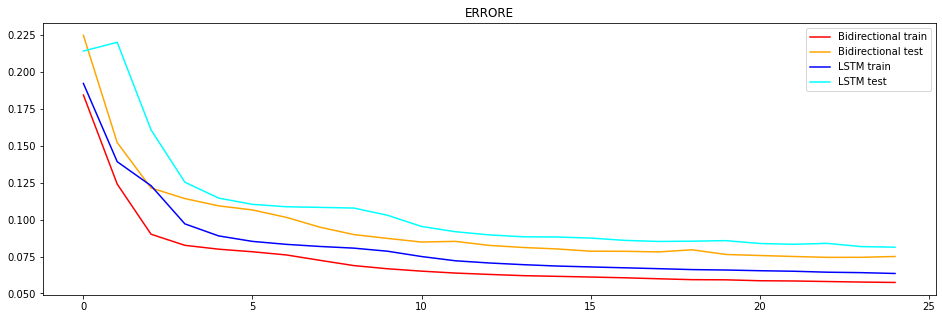

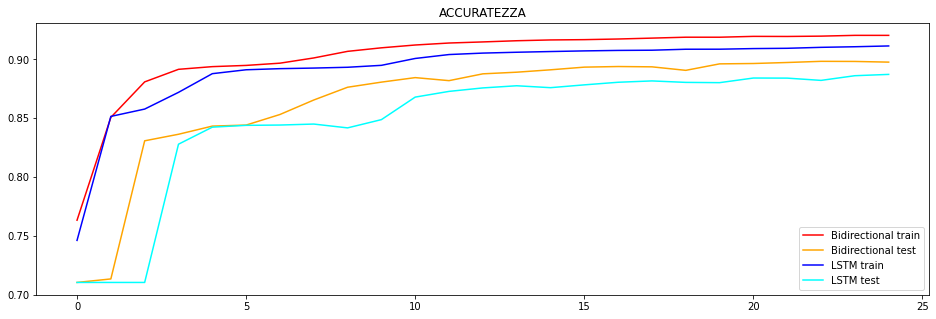

In [33]:
plt.figure(figsize=(16,5))
plt.plot(bidirectional_history.history['loss'], label='Bidirectional train', color='red')
plt.plot(bidirectional_history.history['val_loss'], label='Bidirectional test', color='orange')
plt.plot(lstm_history.history['loss'], label='LSTM train', color='blue')
plt.plot(lstm_history.history['val_loss'], label='LSTM test', color='cyan')
plt.title('ERRORE')
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.plot(bidirectional_history.history['binary_accuracy'], label='Bidirectional train', color='red')
plt.plot(bidirectional_history.history['val_binary_accuracy'], label='Bidirectional test', color='orange')
plt.plot(lstm_history.history['binary_accuracy'], label='LSTM train', color='blue')
plt.plot(lstm_history.history['val_binary_accuracy'], label='LSTM test', color='cyan')
plt.title('ACCURATEZZA')
plt.legend()
plt.show()

In [34]:
print('Accuratezza modello LSTM', lstm_model.evaluate(x_test, y_test))
print('Tempo di addestramento LSTM:', lstm_training_time)

print('')

print('Accuratezza modello Bidirectional', bidirectional_model.evaluate(x_test, y_test))
print('Tempo di addestramento Bidirectional LSTM:', bidirectional_training_time)

186/186 [==============================] - 0s 1ms/step - loss: 0.0814 - binary_accuracy: 0.8872
Accuratezza modello LSTM [0.08135361969470978, 0.8871994614601135]
Tempo di addestramento LSTM: 0:00:37.733565

186/186 [==============================] - 0s 2ms/step - loss: 0.0751 - binary_accuracy: 0.8976